In [58]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [59]:
import warnings

import numpy as np
import pandas as pd
from cobra.io import read_sbml_model
from utils.cobra_utils import get_or_create_exchange, set_active_bound

# Load the model
model = read_sbml_model("../model/Rpom_05.xml")
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# TODO: Remove all of the below
# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
# atpm.bounds = (25, 25)

In [60]:
with model:
    ex_ace.bounds = (0, 0)
    ex_glc.bounds = (-10, 0)

    sol1 = model.optimize()

    problematique = model.reactions.get_by_id("VALINE-PYRUVATE-AMINOTRANSFER-RXN")
    problematique.bounds = (0, 0)

    sol2 = model.optimize()

print(f"With valine-pyruvate-aminotransferase: {sol1.objective_value:.2f}")
print(f"Without valine-pyruvate-aminotransferase: {sol2.objective_value:.2f}")

flux_diffs = sol1.fluxes - sol2.fluxes
flux_diffs = flux_diffs[flux_diffs != 0]
flux_diffs.sort_values(ascending=False).reset_index().rename(columns={"index": "reaction_id", "fluxes": "flux with - flux without"})

With valine-pyruvate-aminotransferase: 1.13
Without valine-pyruvate-aminotransferase: 1.12


,reaction_id,flux with - flux without
0,METHENYLTHFCYCLOHYDRO-RXN,0.754270
1,1.5.1.15-RXN,0.754270
2,1.2.1.2-RXN,0.751077
3,BRANCHED-CHAINAMINOTRANSFERVAL-RXN,0.486272
4,VALINE-PYRUVATE-AMINOTRANSFER-RXN,0.483544
...,...,...
408,RXN-8,-0.480226
409,AMINOBUTDEHYDROG-RXN,-0.480226
410,1.10.2.2-RXN,-0.562558
411,FORMATETHFLIG-RXN,-0.751062


In [45]:
sol1.fluxes["METHENYLTHFCYCLOHYDRO-RXN"]

10.491854118611666

In [44]:
sol2.fluxes["METHENYLTHFCYCLOHYDRO-RXN"]

9.733838563736297

In [54]:
model.reactions.get_by_id("AMINOBUTDEHYDROG-RXN")

Reaction identifier,AMINOBUTDEHYDROG-RXN
Name,AMINOBUTDEHYDROG-RXN
Memory address,0x7f84f49dcf80
Stoichiometry,4-AMINO-BUTYRALDEHYDE[c] + NAD[c] + WATER[c] --> 4-AMINO-BUTYRATE[c] + NADH[c] + 2.0 PROTON[c] 4-aminobutanal + NAD+ + H2O --> 4-aminobutanoate + NADH + 2.0 H+
GPR,
Lower bound,0.0
Upper bound,1000.0


In [51]:
sol2.fluxes[sol1.fluxes != sol2.fluxes][sol1.fluxes==0]

AMINOBUTDEHYDROG-RXN    0.480226
Name: fluxes, dtype: float64

In [61]:
data = pd.read_excel("../../Additional R pom data/substrates Rpom grows on.xlsx")
data

,Substrate,BIOCYC ID,Growth (yes/no),Notes
0,"2,3-dihydroxypropane-1-sulfonate","2-3-dihydroxypropane-1-sulfonate, CPD-12692, C...",yes,NaN
1,3-Mercaptopropionate,CPD-7672,no,NaN
2,4-Amino-5-aminomethyl-2-methylpyrimidine,CPD-13578,no,NaN
3,4-Aminobenzoic acid,P-AMINO-BENZOATE,no,NaN
4,Acetate,ACET,yes,NaN
...,...,...,...,...
71,Tyramine,TYRAMINE,yes,NaN
72,Tyrosine,TYR,yes,NaN
73,Valine,VAL,yes,NaN
74,Xylose,"CPD-25028, BETA-D-XYLOSE",yes,NaN


In [62]:
presence_c = [np.mean([f"{met}[c]" in model.metabolites for met in metid.split(", ")]) if isinstance(metid, str) else 0 for metid in data["BIOCYC ID"]]
presence_p = [np.mean([f"{met}[p]" in model.metabolites for met in metid.split(", ")]) if isinstance(metid, str) else 0 for metid in data["BIOCYC ID"]]
presence_e = [np.mean([f"{met}[e]" in model.metabolites for met in metid.split(", ")]) if isinstance(metid, str) else 0 for metid in data["BIOCYC ID"]]

In [63]:
data["In model [c]"] = presence_c
data["In model [p]"] = presence_p
data["In model [e]"] = presence_e
data

,Substrate,BIOCYC ID,Growth (yes/no),Notes,In model [c],In model [p],In model [e]
0,"2,3-dihydroxypropane-1-sulfonate","2-3-dihydroxypropane-1-sulfonate, CPD-12692, C...",yes,NaN,0.666667,0.333333,0.333333
1,3-Mercaptopropionate,CPD-7672,no,NaN,1.000000,0.000000,0.000000
2,4-Amino-5-aminomethyl-2-methylpyrimidine,CPD-13578,no,NaN,1.000000,0.000000,0.000000
3,4-Aminobenzoic acid,P-AMINO-BENZOATE,no,NaN,1.000000,0.000000,0.000000
4,Acetate,ACET,yes,NaN,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...
71,Tyramine,TYRAMINE,yes,NaN,1.000000,0.000000,0.000000
72,Tyrosine,TYR,yes,NaN,1.000000,1.000000,0.000000
73,Valine,VAL,yes,NaN,1.000000,1.000000,0.000000
74,Xylose,"CPD-25028, BETA-D-XYLOSE",yes,NaN,0.500000,0.500000,0.500000


In [64]:
data

,Substrate,BIOCYC ID,Growth (yes/no),Notes,In model [c],In model [p],In model [e]
0,"2,3-dihydroxypropane-1-sulfonate","2-3-dihydroxypropane-1-sulfonate, CPD-12692, C...",yes,NaN,0.666667,0.333333,0.333333
1,3-Mercaptopropionate,CPD-7672,no,NaN,1.000000,0.000000,0.000000
2,4-Amino-5-aminomethyl-2-methylpyrimidine,CPD-13578,no,NaN,1.000000,0.000000,0.000000
3,4-Aminobenzoic acid,P-AMINO-BENZOATE,no,NaN,1.000000,0.000000,0.000000
4,Acetate,ACET,yes,NaN,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...
71,Tyramine,TYRAMINE,yes,NaN,1.000000,0.000000,0.000000
72,Tyrosine,TYR,yes,NaN,1.000000,1.000000,0.000000
73,Valine,VAL,yes,NaN,1.000000,1.000000,0.000000
74,Xylose,"CPD-25028, BETA-D-XYLOSE",yes,NaN,0.500000,0.500000,0.500000


In [65]:
from cobra.core import Metabolite, Reaction

growth = []
for metid, presence in zip(data["BIOCYC ID"], data["In model [c]"]):
    if presence:
        growth_rates = []
        for met in metid.split(", "):
            with model:
                # Pass over cytosolic metabolites that don't exist
                try:
                    met_c = model.metabolites.get_by_id(met + "[c]")
                except:
                    continue

                # Get or create external metabolite
                try:
                    met_e = model.metabolites.get_by_id(f"{met}[e]")
                except:
                    met_e = Metabolite(f"{met}[e]", name=met, compartment="e")
                    model.add_metabolites([met_e])
                
                # Get or create exchange reaction
                ex_met = get_or_create_exchange(model, met_e.id)

                # Create transport reaction
                transport = Reaction("test", "", lower_bound=-1000, upper_bound=1000)
                transport.add_metabolites({
                    met_e : -1,
                    met_c : 1
                })
                model.add_reactions([transport])

                # Bound and solve
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    set_active_bound(ex_met, 10)
                    sol = model.optimize()
                    growth_rates.append(sol.objective_value)
        
        growth.append(growth_rates)
    else:
        growth.append([0])

In [66]:
print(data.to_string())

                                   Substrate                                                                                                           BIOCYC ID Growth (yes/no)                                                        Notes  In model [c]  In model [p]  In model [e]
0           2,3-dihydroxypropane-1-sulfonate                                                              2-3-dihydroxypropane-1-sulfonate, CPD-12692, CPD-12693             yes                                                          NaN      0.666667      0.333333      0.333333
1                       3-Mercaptopropionate                                                                                                            CPD-7672              no                                                          NaN      1.000000      0.000000      0.000000
2   4-Amino-5-aminomethyl-2-methylpyrimidine                                                                                                           CPD-13578

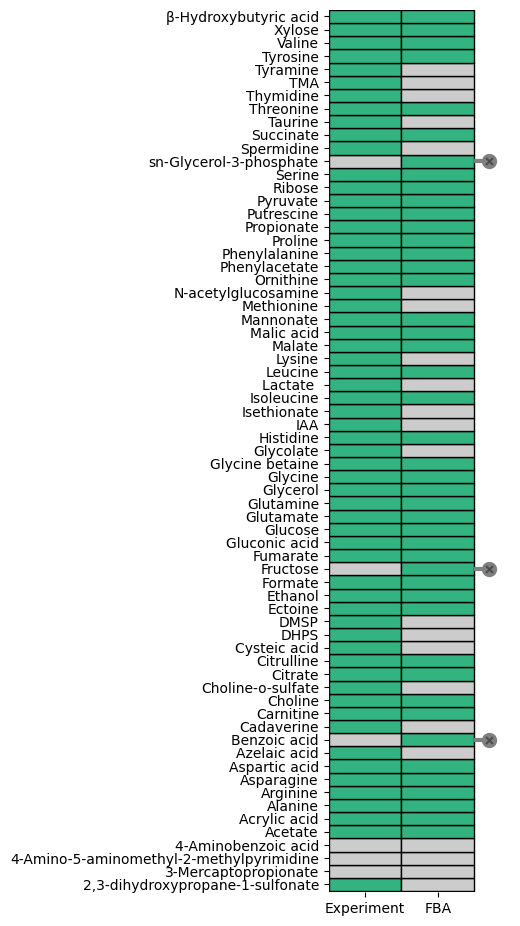

In [67]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

data["Model Growth"] = [np.mean([g_i > 0 for g_i in g]) for g in growth]

# Create a figure and axes
fig, ax = plt.subplots()

# Get experimental and model growth for heatmap
true_growth = (data["Growth (yes/no)"] == "yes")[data["In model [c]"] > 0].values
model_growth = data["Model Growth"][data["In model [c]"] > 0].values

# Create the heatmap
cmap = LinearSegmentedColormap.from_list("", ["0.8", (0.2, 0.7, 0.5)])

patches = []
for y, (g_true, g_model) in enumerate(np.array([true_growth, model_growth]).T):
    if presence:
        patches.append(Rectangle((0, y), 1, 1, color=cmap(g_true), ec="k"))
        patches.append(Rectangle((1, y), 1, 1, color=cmap(g_model), ec="k"))

pc = PatchCollection(patches, match_original=True)
ax.add_collection(pc)

# Add lollipops to indicate metabolites for which we can infer there is no transport
no_transport = np.where(~true_growth & (model_growth > 0.5))[0]
STEM_LENGTH = 0.15
ax.hlines(0.5 + no_transport, 2, 2 + STEM_LENGTH, color="0.5", lw=3)
ax.scatter([2 + STEM_LENGTH + 0.05] * len(no_transport),
           0.5 + no_transport, s=100, color="0.5", marker="o")
ax.scatter([2 + STEM_LENGTH + 0.05] * len(no_transport),
           0.5 + no_transport, s=25, color="0.3", marker="x")

ax.set_xlim(0, 2.5)
ax.set_ylim(-0.1, len(model_growth))

# Set the tick labels and positions
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(["Experiment", "FBA"])
ax.set_yticks(0.5 + np.arange(len(data["Substrate"][data["In model [c]"] > 0])))
ax.set_yticklabels(data["Substrate"][data["In model [c]"] > 0])

# Add a colorbar
# cbar = fig.colorbar(heatmap)

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set size
fig.tight_layout()
fig.set_size_inches(4, 10)

In [10]:
data["Substrate"][data["In model [c]"] > 0]

0             2,3-dihydroxypropane-1-sulfonate
1                         3-Mercaptopropionate
2     4-Amino-5-aminomethyl-2-methylpyrimidine
3                          4-Aminobenzoic acid
4                                      Acetate
                        ...                   
69                                   Thymidine
72                                    Tyrosine
73                                      Valine
74                                      Xylose
75                       β-Hydroxybutyric acid
Name: Substrate, Length: 62, dtype: object

In [11]:
data["In model [c]"]

0     0.666667
1     1.000000
2     1.000000
3     1.000000
4     1.000000
        ...   
71    0.000000
72    1.000000
73    1.000000
74    0.500000
75    1.000000
Name: In model [c], Length: 76, dtype: float64

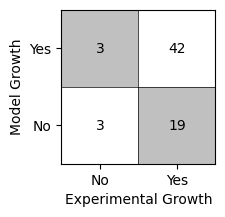

In [68]:
from collections import Counter
counts = Counter(zip(true_growth.astype(int), model_growth))

fig, ax = plt.subplots()
img = ax.imshow(np.array([[1, 0],
                          [0, 1]]), cmap="Greys_r", alpha=0.25)

for (true, model_grows), count in counts.items():
    ax.text(true, model_grows, count, ha="center", va="center")


ax.hlines(0.5, -0.5, 1.5, color="0", lw=0.5)
ax.vlines(0.5, -0.5, 1.5, color="0", lw=0.5)

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["No", "Yes"])
ax.set_yticklabels(["No", "Yes"])
ax.set_xlabel("Experimental Growth")
ax.set_ylabel("Model Growth")
ax.set_aspect("equal")
fig.set_size_inches(2, 2)

EX_glt: GLT[e] <=>  bounds: (-3, 1000.0)
EX_ILE[e]: ILE[e] <=>  bounds: (-3, 1000.0)
EX_L-ALPHA-ALANINE[e]: L-ALPHA-ALANINE[e] <=>  bounds: (-3, 1000.0)
EX_L-ASPARTATE[e]: L-ASPARTATE[e] <=>  bounds: (-3, 1000.0)
EX_LEU[e]: LEU[e] <=>  bounds: (-3, 1000.0)
EX_PHE[e]: PHE[e] <=>  bounds: (-3, 1000.0)
EX_PRO[e]: PRO[e] <=>  bounds: (-3, 1000.0)
EX_VAL[e]: VAL[e] <=>  bounds: (-3, 1000.0)


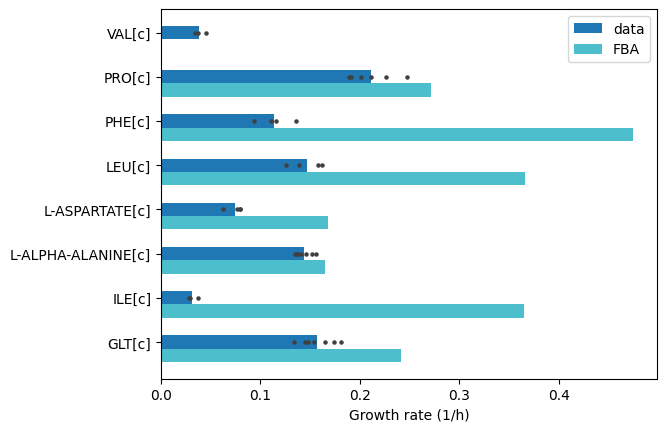

In [70]:
# Compare growth rates for substrates on which we have data
# Grown on L1 medium with 3 mM C
mu_df = pd.read_csv("../data/clean/growth/growth_rates.csv")

substrates = []
growth_rates = []
for met, mu in mu_df.groupby("ID")["mu"].mean().items():
    met = met.split("[")[0]
    substrates.append(met)

    # Get model growth rate
    with model:
        # Get cytosolic metabolite
        met_c = model.metabolites.get_by_id(met + "[c]")
        
        # Get or create external metabolite
        try:
            met_e = model.metabolites.get_by_id(f"{met}[e]")
        except:
            met_e = Metabolite(f"{met}[e]",
                               formula=met_c.formula,
                               name=met,
                               compartment="e")
            model.add_metabolites([met_e])

        # Get or create exchange reaction
        ex_met = get_or_create_exchange(model, met_e.id)

        # Create transport reaction
        transport = Reaction("test", "", lower_bound=-1000, upper_bound=1000)
        transport.add_metabolites({
            met_e : -1,
            met_c : 1
        })
        model.add_reactions([transport])

        # Turn off VALINE-PYRUVATE-AMINOTRANSFER-RXN
        problematique = model.reactions.get_by_id("VALINE-PYRUVATE-AMINOTRANSFER-RXN")
        problematique.bounds = (0, 0)

        # Bound and solve
        set_active_bound(ex_met, 3)
        print(f"{ex_met} bounds: {ex_met.bounds}")
        sol = model.optimize()

        if sol.status != "infeasible":
            growth_rates.append(sol.objective_value)
        else:
            growth_rates.append(0)

mu_means = mu_df.groupby("ID")["mu"].mean()

met_y = {
    met : i for i, met in enumerate(mu_means.index)
}

fig, ax = plt.subplots()
ax.barh([met_y[met] for met in mu_means.index],
        mu_means,
        label="data",
        height=0.3)
ax.barh([met_y[met] - 0.3 for met in mu_means.index],
        growth_rates,
        color=(0.3, 0.75, 0.8),
        label="FBA",
        height=0.3)
ax.scatter(mu_df["mu"], [met_y[met] for met in mu_df["ID"]], color="0.25", s=5)

ax.set_yticks(np.arange(len(mu_means)), mu_means.index)

ax.set_xlabel("Growth rate (1/h)")
ax.legend()

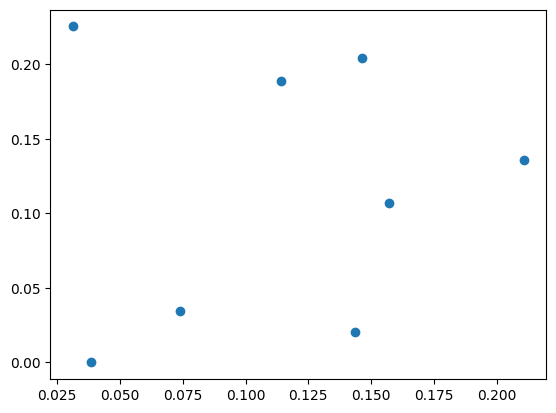

In [14]:
fig, ax = plt.subplots()
ax.scatter(mu_means, growth_rates)